In [102]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [103]:
data = pd.read_csv('movies_metadata.csv')

C:\Users\csky2\AppData\Local\Temp\ipykernel_11000\1532675202.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('movies_metadata.csv')


## Data quality check / cleaning / preparation 

### Distribution of response
*By Tess Wagner*

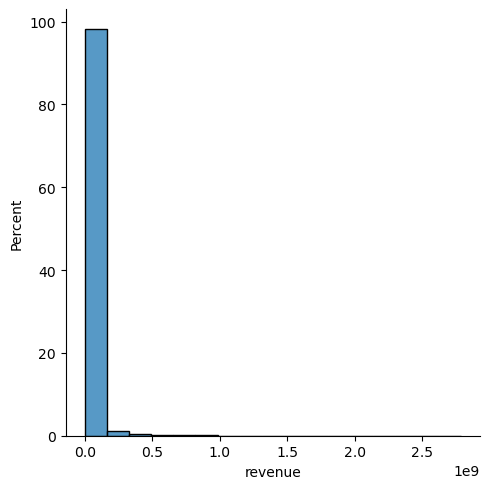

In [104]:
sns.displot(data.revenue, stat='percent')

In [105]:
data.describe()[['revenue']]

,revenue
count,4.546000e+04
mean,1.120935e+07
std,6.433225e+07
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,0.000000e+00
max,2.787965e+09


### Data cleaning
*By Tess Wagner*

Getting rid of movies that were not released. These were never shown to an audience, so these are not helpful.

In [106]:
data = data.drop(np.where(data['status'] != 'Released')[0])

In [107]:
data.adult.value_counts()

False    45006
True         8
Name: adult, dtype: int64

# should we keep adult?
Getting rid of columns that will not help us predict revenue.
- Most are unique to each movie (aka the movie website or id number)
- Some columns (like vote_average) come out after the movies are released, so they are not helpful in predicting movie revenue before the films are released.

In [108]:
data = data.drop(['adult', 'homepage', 'id', 'imdb_id', 'original_title', 'poster_path', 'status', 'video', 'overview', 'production_companies', 'production_countries', 'spoken_languages', 'tagline', 'popularity', 'vote_average', 'vote_count'], axis=1)

Changing release date to a datetime object to make it useable.

In [109]:
data.release_date = pd.to_datetime(data.release_date)

Dropping the movies with no release date. We chose not to impute this variable because it is unlikely that there is a method to impute it even somewhat correctly based on the qualities of other movies in the dataset.

In [110]:
data.drop(data[data.release_date.isna()].index, inplace = True)

We also decided to drop the movies with missing values for runtime. We were not concerned about this affecting our predictions too much since those movies only made up 0.5% of the entire dataset.

In [111]:
data.drop(data[data.runtime.isna()].index, inplace = True)

### Data preparation
*By Tess Wagner*

The following data preparation steps helped us to prepare our data for implementing various modeling / validation techniques:

1. Since we are predicting if a movie will produce revenue or not, we adapted the response variable and a few of the predictors into binary values to make it easier to determine the relationships between the predictors and the response.

2. Many of the predictors were categorical and contained thousands of possible values. Since the format of these predictors would make them difficult to use in a model, we turned them into dummy variables.

In the original dataset, `revenue` is a continuous variable. We are trying to predict whether a movie produced revenue or not, so we changed this to a binary variable.

In [112]:
data.loc[data['revenue']!=0, 'revenue'] = 1
data.loc[data['revenue']==0, 'revenue'] = 0

In the original dataset, `belongs_to_collection` contains the collection name that a movie belongs to. For all the movies that are not part of a collection, this column contains a missing value. To make this more useful, we are changing this column to contain binary information about whether a movie belongs to a collection or not.

In [113]:
data.loc[~data.belongs_to_collection.isnull(), 'belongs_to_collection'] = 1
data.loc[data.belongs_to_collection.isnull(), 'belongs_to_collection'] = 0

In the original dataset, there are multiple genres listed for each movie in the `genre` column. We decided to create dummy variables for each genre to better understand the relation between each individual genre and the response variable

In [114]:
def get_dummies_complex(column_name):
    column_name = column_name.apply(lambda x:eval(x))
    dict_items = []
    for list_of_dicts in column_name:
        for dictionary in list_of_dicts:
            if dictionary['name'] not in dict_items:
                dict_items.append(dictionary['name'])
    for item in dict_items:
        data[item] = 0
    for ind in data.index:
        items = column_name[ind]
        for dictionary in items:
            data.loc[ind, dictionary['name']] = 1
    return data

get_dummies_complex(data.genres)

# getting rid of the original genres column as we no longer need it
data.drop('genres', axis=1, inplace = True)

We are making the variable `original_language` into a binary response of movies that are in English vs not in English.

In [115]:
ind = data.loc[data.original_language.isin(['en']), 'original_language'].index
data['english'] = 0
for movie in ind:
    data.loc[ind, 'english'] = 1
    
# dropping original_language as we no longer need it
data.drop('original_language', axis = 1, inplace = True)

Because each release date is typically unique each movie, we figured it would be more useful to look at the release month and release year of each movie.

In [116]:
data['release_year'] = data.release_date.dt.to_period("Y").astype(int)
data['release_month'] = data.release_date.dt.month
data.drop('release_date', axis = 1, inplace = True)

C:\Users\csky2\AppData\Local\Temp\ipykernel_11000\4003150984.py:1: FutureWarning: The behavior of .astype from period[A-DEC] to int32 is deprecated. In a future version, this astype will return exactly the specified dtype instead of int64, and will raise if that conversion overflows.
  data['release_year'] = data.release_date.dt.to_period("Y").astype(int)


Changing `budget` from an object type to an int type.

In [127]:
data.budget = data.budget.astype(int)

## Exploratory data analysis

### Distribution of response (as a binary variable)
*By Tess Wagner*

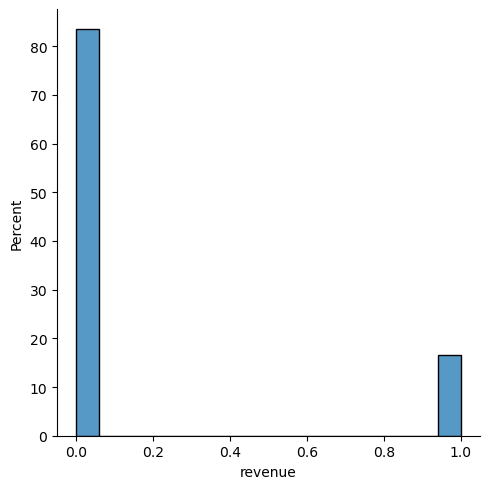

In [117]:
sns.displot(data.revenue, stat='percent')

### Distribution of each predictor
*By Tess Wagner*

<Axes: xlabel='release_month', ylabel='Count'>

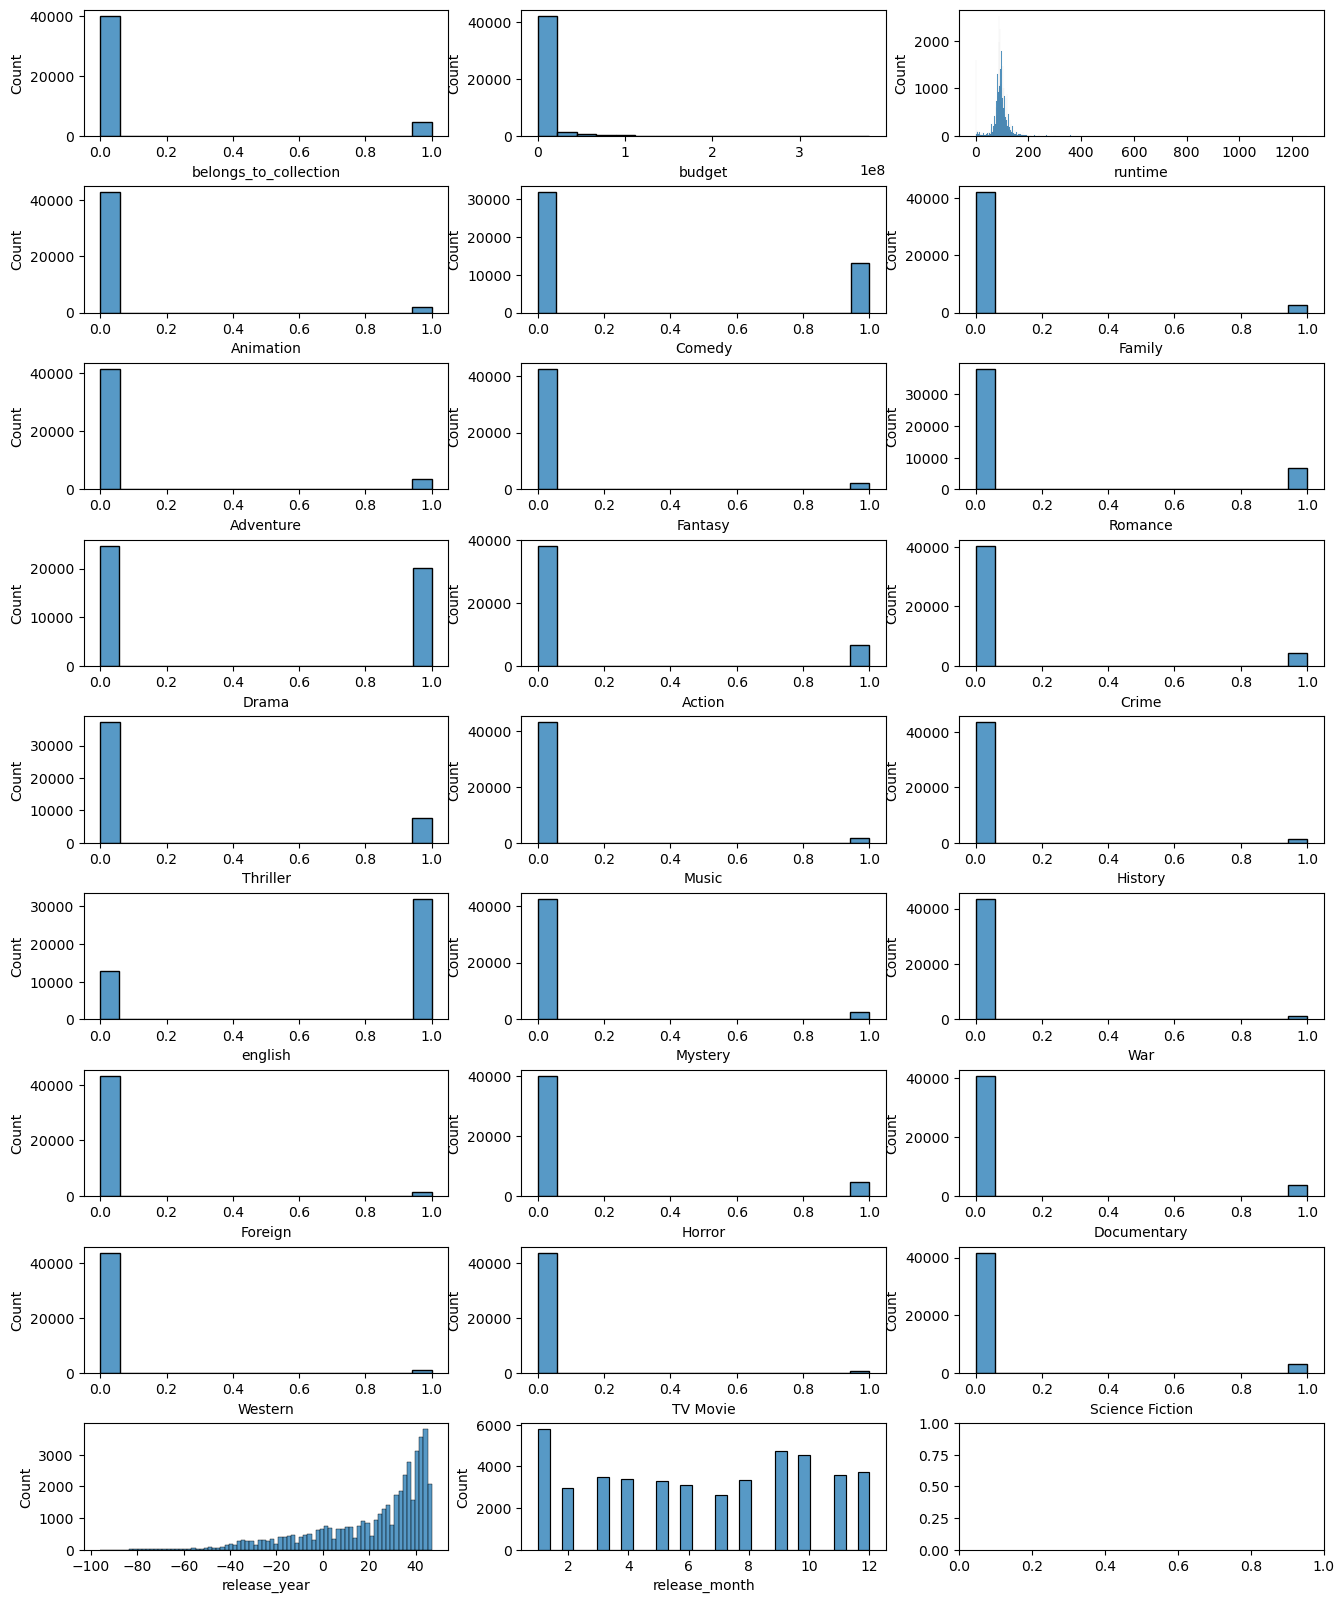

In [133]:
fig, axes = plt.subplots(nrows = 9, ncols = 3, figsize = (16,20))
plt.subplots_adjust(wspace = 0.2, hspace = 0.4)
plt.ylim(0,1)

sns.histplot(ax = axes[0,0], data = data.belongs_to_collection)
sns.histplot(ax = axes[0,1], data = data.budget)
sns.histplot(ax = axes[0,2], data = data.runtime)
sns.histplot(ax = axes[1,0], data = data.Animation)
sns.histplot(ax = axes[1,1], data = data.Comedy)
sns.histplot(ax = axes[1,2], data = data.Family)
sns.histplot(ax = axes[2,0], data = data.Adventure)
sns.histplot(ax = axes[2,1], data = data.Fantasy)
sns.histplot(ax = axes[2,2], data = data.Romance)
sns.histplot(ax = axes[3,0], data = data.Drama)
sns.histplot(ax = axes[3,1], data = data.Action)
sns.histplot(ax = axes[3,2], data = data.Crime)
sns.histplot(ax = axes[4,0], data = data.Thriller)
sns.histplot(ax = axes[4,1], data = data.Music)
sns.histplot(ax = axes[4,2], data = data.History)
sns.histplot(ax = axes[5,0], data = data.english)
sns.histplot(ax = axes[5,1], data = data.Mystery)
sns.histplot(ax = axes[5,2], data = data.War)
sns.histplot(ax = axes[6,0], data = data.Foreign)
sns.histplot(ax = axes[6,1], data = data.Horror)
sns.histplot(ax = axes[6,2], data = data.Documentary)
sns.histplot(ax = axes[7,0], data = data.Western)
sns.histplot(ax = axes[7,1], data = data['TV Movie'])
sns.histplot(ax = axes[7,2], data = data['Science Fiction'])
sns.histplot(ax = axes[8,0], data = data.release_year)
sns.histplot(ax = axes[8,1], data = data.release_month)

### Response plotted against each predictor
*By Tess Wagner*

<Axes: xlabel='release_month', ylabel='revenue'>

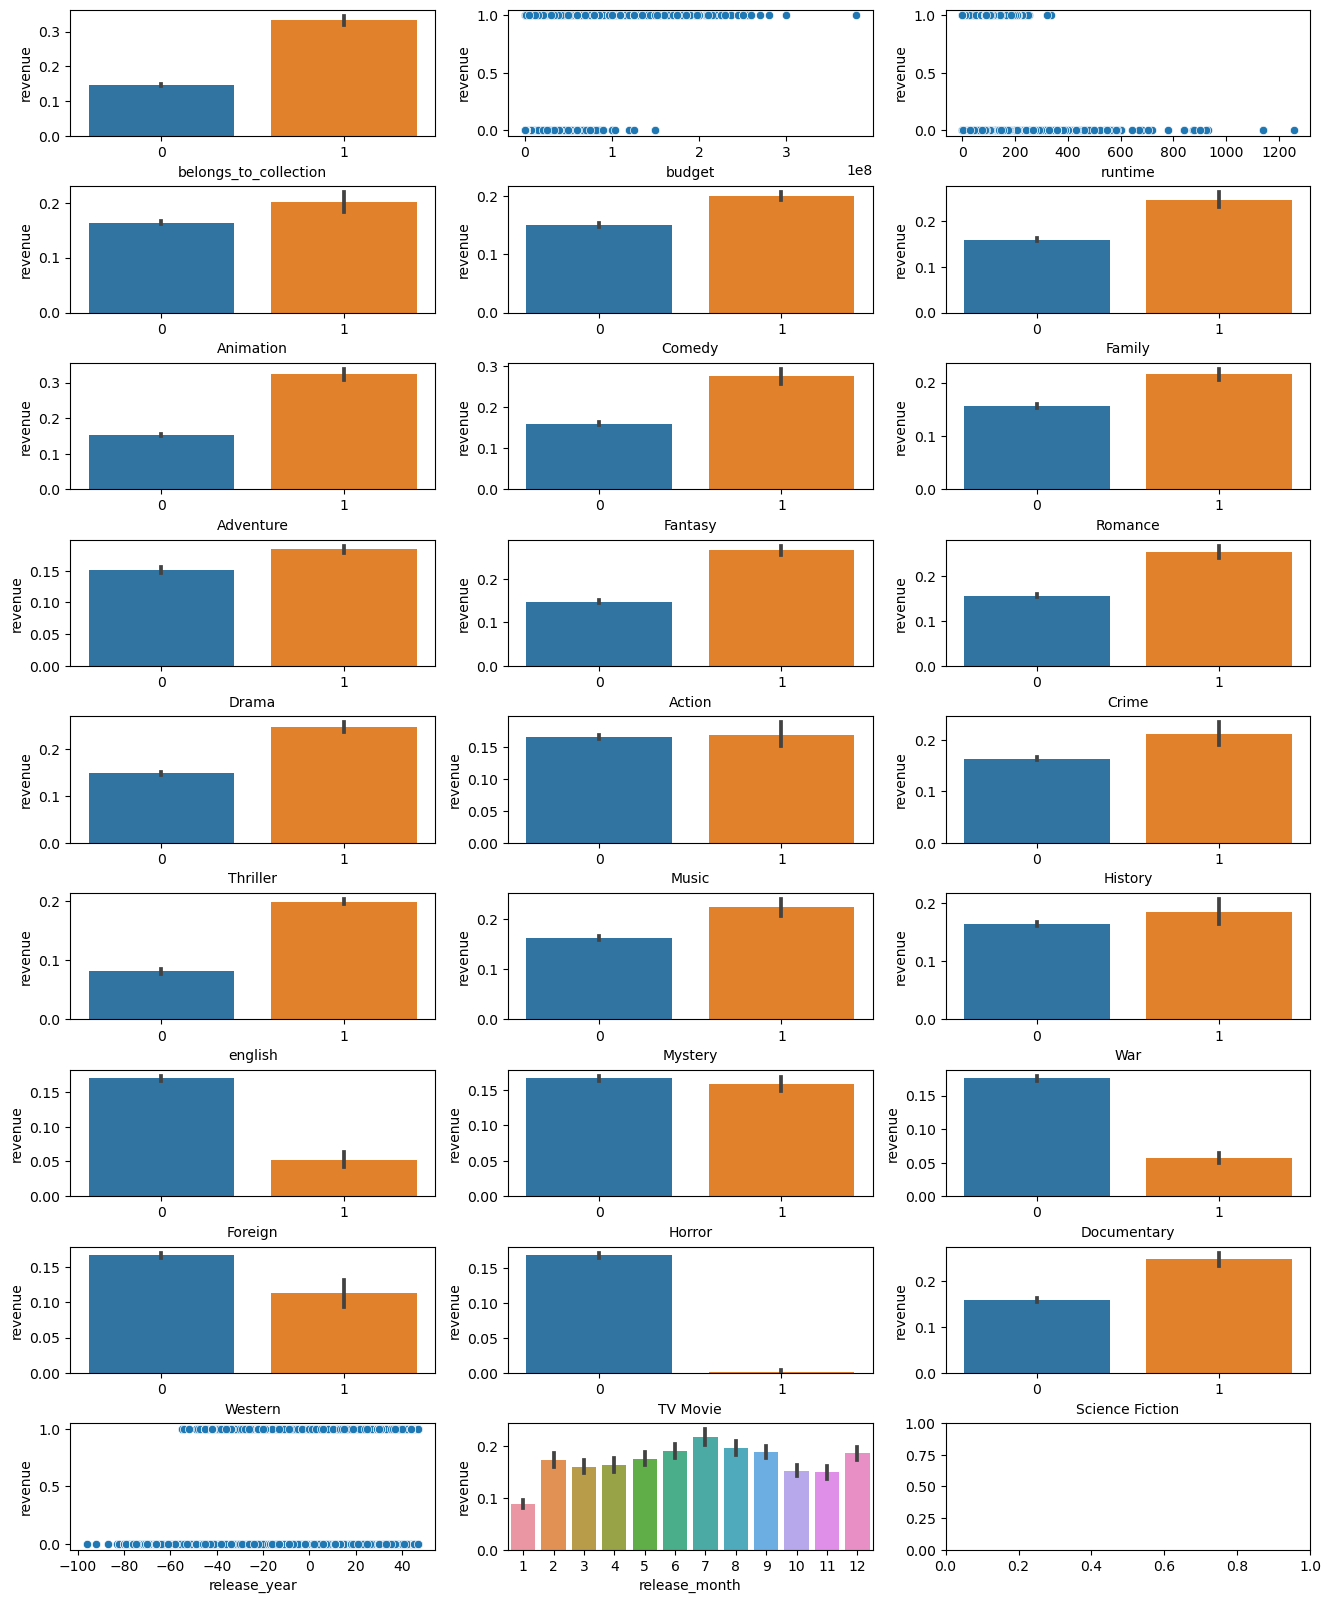

In [130]:
fig, axes = plt.subplots(nrows = 9, ncols = 3, figsize = (16,20))
plt.subplots_adjust(wspace = 0.2, hspace = 0.4)
plt.ylim(0,1)

sns.barplot(ax = axes[0,0], x = data.belongs_to_collection, y = data.revenue)
sns.scatterplot(ax = axes[0,1], x = data.budget, y = data.revenue)
sns.scatterplot(ax = axes[0,2], x = data.runtime, y = data.revenue)
sns.barplot(ax = axes[1,0], x = data.Animation, y = data.revenue)
sns.barplot(ax = axes[1,1], x = data.Comedy, y = data.revenue)
sns.barplot(ax = axes[1,2], x = data.Family, y = data.revenue)
sns.barplot(ax = axes[2,0], x = data.Adventure, y = data.revenue)
sns.barplot(ax = axes[2,1], x = data.Fantasy, y = data.revenue)
sns.barplot(ax = axes[2,2], x = data.Romance, y = data.revenue)
sns.barplot(ax = axes[3,0], x = data.Drama, y = data.revenue)
sns.barplot(ax = axes[3,1], x = data.Action, y = data.revenue)
sns.barplot(ax = axes[3,2], x = data.Crime, y = data.revenue)
sns.barplot(ax = axes[4,0], x = data.Thriller, y = data.revenue)
sns.barplot(ax = axes[4,1], x = data.Music, y = data.revenue)
sns.barplot(ax = axes[4,2], x = data.History, y = data.revenue)
sns.barplot(ax = axes[5,0], x = data.english, y = data.revenue)
sns.barplot(ax = axes[5,1], x = data.Mystery, y = data.revenue)
sns.barplot(ax = axes[5,2], x = data.War, y = data.revenue)
sns.barplot(ax = axes[6,0], x = data.Foreign, y = data.revenue)
sns.barplot(ax = axes[6,1], x = data.Horror, y = data.revenue)
sns.barplot(ax = axes[6,2], x = data.Documentary, y = data.revenue)
sns.barplot(ax = axes[7,0], x = data.Western, y = data.revenue)
sns.barplot(ax = axes[7,1], x = data['TV Movie'], y = data.revenue)
sns.barplot(ax = axes[7,2], x = data['Science Fiction'], y = data.revenue)
sns.scatterplot(ax = axes[8,0], x = data.release_year, y = data.revenue)
sns.barplot(ax = axes[8,1], x = data.release_month, y = data.revenue)

## Developing the model: Hyperparameter tuning

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

Put each model in a section of its name and mention the name of the team-member tuning the model. Below is an example:

### Lasso, Ridge & Catboost
*By Sylvia Sherwood*

### MARS, AdaBoost & LightGBM
*By Sankaranarayanan Balasubramanian*

### Bagged trees & Random forest
*By Fiona Fe*

### XGBoost
*By Ryu Kimiko*

## Model Ensemble 

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**


### Voting ensemble

### Stacking ensemble(s)

### Ensemble of ensembled models

### Innovative ensembling methods
*(Optional)*

## Conclusions and Recommendations to stakeholder(s)

You may or may not have code to put in this section. Delete this section if it is irrelevant.